## Configura tabelas e importa libs

In [0]:
%python
# Lista de arquivos e tabelas
tabelas = [
    ("df_comercio", "/FileStore/tables/df_comercio-4.csv"),
    ("df_exportacao", "/FileStore/tables/df_exportacao-6.csv"),
    ("df_importacao", "/FileStore/tables/df_importacao-2.csv"),
    ("df_processamento", "/FileStore/tables/df_processamento-3.csv"),
    ("df_producao", "/FileStore/tables/df_producao-3.csv")
]

# Parâmetros comuns de leitura
file_type = 'csv'
infer_schema = 'true'
first_row_is_header = 'true'
delimiter = ','
thousands = '.'
decimal = ','


# Loop para processar cada tabela
for table_name, file_location in tabelas:
    # Remove a tabela do metastore (se existir)
    spark.sql(f"DROP TABLE IF EXISTS default.{table_name}")
    
    # Remove o diretório físico da tabela (se existir)
    dbutils.fs.rm(f"dbfs:/user/hive/warehouse/{table_name}", recurse=True)

# Loop para processar cada tabela
for table_name, file_location in tabelas:
    df = spark.read.format(file_type) \
        .option('inferSchema', infer_schema) \
        .option('header', first_row_is_header) \
        .option('sep', delimiter) \
        .option('multiLine', 'true') \
        .option('quote', '"') \
        .option('escape', '"') \
        .option('thousands', thousands) \
        .option('decimal', decimal) \
        .load(file_location)

    # Salva como tabela no metastore do Databricks
    df.write.mode("overwrite").format("parquet").saveAsTable(f"default.{table_name}")


In [0]:
%python
pip install openpyxl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%python
pip install lxml

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%python
# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import requests
from pyspark.sql import functions as F
from sklearn.preprocessing import MinMaxScaler

import warnings

# Desabilitar todos os warnings
warnings.filterwarnings("ignore")


In [0]:
%python
# importando a base de dados de mercado
mercado = pd.read_excel('https://github.com/victorcbarros/Analise-Exportacao-de-Vinhos/raw/main/data-dados/raw-iniciais/dadosvinhos.xlsx')

In [0]:
%python
# importando a base de dados de população
# extraindo a url
url = 'https://pt.wikipedia.org/wiki/Lista_de_pa%C3%ADses_por_popula%C3%A7%C3%A3o'

# Fazendo a requisição usando requests
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Lendo o HTML para um DataFrame
    populacao = pd.read_html(response.text)[0]
    populacao.head()
else:
    print("Falha ao acessar o site. Status code:", response.status_code)

In [0]:
%python
# criando um função de costumização para usar nos graficos verticais
def grafico_vertical(ax,valor,titulo):
    # Removendo a caixa ao redor do gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # Ajustando a altura do eixo y
    ax.set_ylim(0, valor.max() * 1.1)  # aumenta o limite superior e inferior em 10%
    #removendo o tick do eixo x
    ax.xaxis.set_ticks_position('none')
    # Removendo o label do eixo y
    ax.set_ylabel('',fontsize=10)
    # Removendo o label do eixo x
    ax.set_xlabel('',fontsize=10)
    # Removendo os valores do eixo y
    ax.yaxis.set_ticks([])  # Remove as marcações do eixo y
    ax.yaxis.set_ticklabels([])  # Remove os rótulos do eixo y
    # Ajustando o tamanho das fontes dos ticks
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Definindo o título do gráfico em negrito e tamanho 12
    ax.set_title(titulo, fontweight='bold', fontsize=12)
    # ajustando as porporções
    plt.tight_layout()

In [0]:
%python
# criando um função de costumização para usar nos graficos horizontais
def grafico_horizontal(ax,valor,titulo):
    # Removendo a caixa ao redor do gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # Ajustando a altura do eixo y
    ax.set_xlim(0, valor.max() * 1.1)  # aumenta o limite superior em 10%
    #removendo o tick do eixo y
    ax.yaxis.set_ticks_position('none')
    # Removendo o label do eixo y
    ax.set_ylabel('',fontsize=10)
    # Removendo o label do eixo x
    ax.set_xlabel('',fontsize=10)
    # Removendo os valores do eixo y
    ax.xaxis.set_ticks([])  # Remove as marcações do eixo x
    ax.xaxis.set_ticklabels([])  # Remove os rótulos do eixo x
    # Ajustando o tamanho das fontes dos ticks
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Definindo o título do gráfico em negrito e tamanho 12
    ax.set_title(titulo, fontweight='bold', fontsize=12)
    # ajustando as porporções
    plt.tight_layout()

## Análises

In [0]:
%python

# Consulta Spark SQL
df_producao = spark.sql("SELECT * FROM workspace.pos_fiap.producao")


# Aplica o filtro corretamente em PySpark
df_filtrado = df_producao.filter(
    (~df_producao.produto.isin('VINHO FINO DE MESA (VINIFERA)', 'VINHO DE MESA', 'SUCO', 'DERIVADOS')) &
    (F.lower(df_producao.categoria_produto).startswith('vinho'))
)


In [0]:
%python

# Converte Spark DataFrame para Pandas
df_filtrado_pd = df_filtrado.toPandas()

# calculando a quantidade de vinhos produzidas 
quantidade_produzida = df_filtrado_pd.groupby('categoria_produto')['quantidade_produzida'].sum()
# ordenando os valores em ordem decrescente
quantidade_produzida.sort_values(ascending=False,inplace = True)
# dividindo os valores por bilhão para ficar melhor a visualização
quantidade_produzida = quantidade_produzida / 1_000_000_000

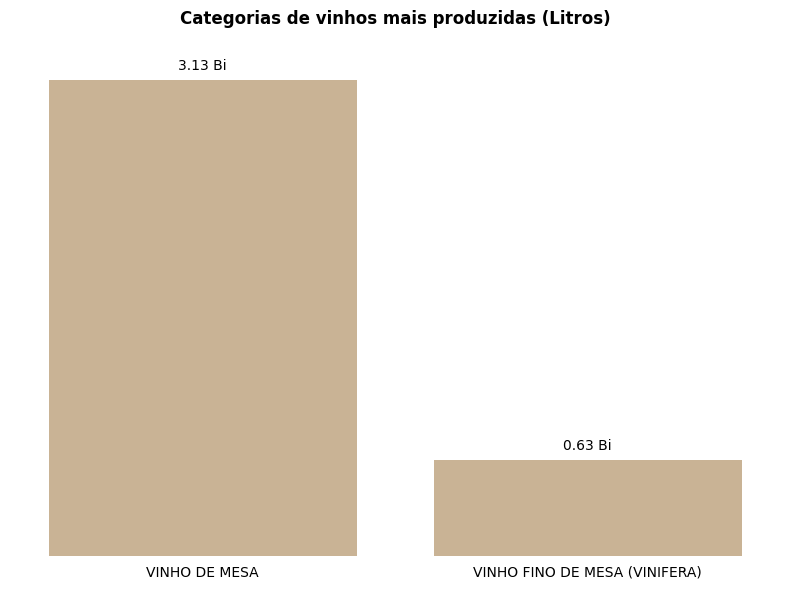

In [0]:
%python
# definindo o tamanho da figura
plt.figure(figsize=(8,6))
# criando o grafico de quantidade de vinhos produzida
ax = sns.barplot(x = quantidade_produzida.index,y = quantidade_produzida.values, color = 'tan')
# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f} Bi',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# adicionando o titulo no grafico 
grafico_vertical(ax,quantidade_produzida,'Categorias de vinhos mais produzidas (Litros)')

In [0]:
%python

# Converte Spark DataFrame para Pandas
df_filtrado_pd = df_filtrado.toPandas()


# criando uma variavel para analisar a produção de vinhos por ano 
producao_por_ano = df_filtrado_pd.groupby('ano')['quantidade_produzida'].sum()
# dividindo o valor por milhão para facilitar a vizualização 
producao_por_ano = producao_por_ano / 1_000_000
#criando um dataframe 
producao_por_ano = producao_por_ano.reset_index()
# criando uma coluna com a Média
producao_por_ano['Média'] = producao_por_ano['quantidade_produzida'].mean()
# Arredondando os valores
producao_por_ano = producao_por_ano.round(0)


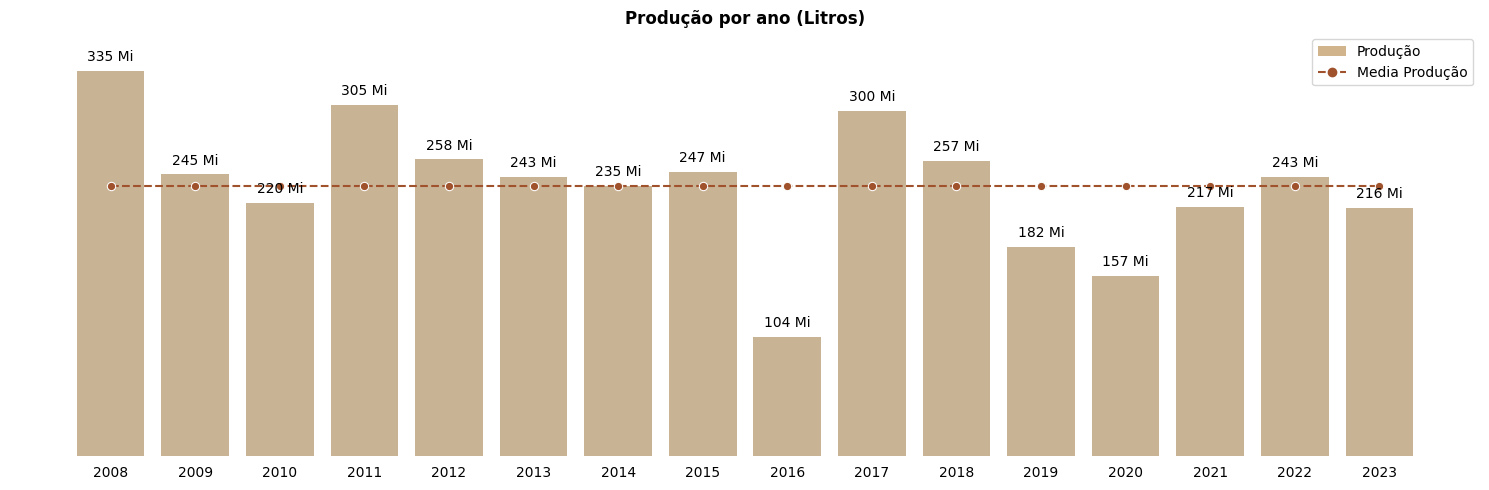

In [0]:
%python

#Ajusta type da coluna de ano
producao_por_ano['ano'] = producao_por_ano['ano'].astype(str)

#criando o grafico 1 
plt.figure(figsize=(15,5))
ax = sns.barplot(data = producao_por_ano, x =  'ano', y = 'quantidade_produzida' ,color = 'tan' )
# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f} Mi',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# criando o grafico 2 
sns.lineplot(data = producao_por_ano, x =  'ano', y = 'Média' ,color = 'sienna', marker = 'o',linestyle = '--')


# Adicionando legendas para cada gráfico
line = plt.Line2D([], [], color='sienna', marker='o', linestyle='--', label='Media Produção')
bar = plt.Rectangle((0, 0), 1, 1, fc='tan', edgecolor='none', label='Produção')
plt.legend(handles=[bar, line], loc='upper right')
# chamando nossa função de grafico 
grafico_vertical(ax,producao_por_ano['quantidade_produzida'],'Produção por ano (Litros)')
plt.show()

In [0]:
%python
# Converte Spark DataFrame para Pandas
df_filtrado_pd = df_filtrado.toPandas()
# calculando a produção entre 2008 e 2015
producao_2008_2015 =  (df_filtrado_pd.groupby('ano')['quantidade_produzida'].sum()[:8].sum() / 1_000_000_000).round(1)
# calculando a produção entre 2016 e 2022
producao_2016_2023 =  (df_filtrado_pd.groupby('ano')['quantidade_produzida'].sum()[8:].sum() / 1_000_000_000).round(1)
# criando um dataframe com esse intervalo 
intervalo = {'2008 - 2015': producao_2008_2015, '2016 - 2023': producao_2016_2023} 
df_intervalo = pd.DataFrame(list(intervalo.items()),columns =['Periodo','Valor'])

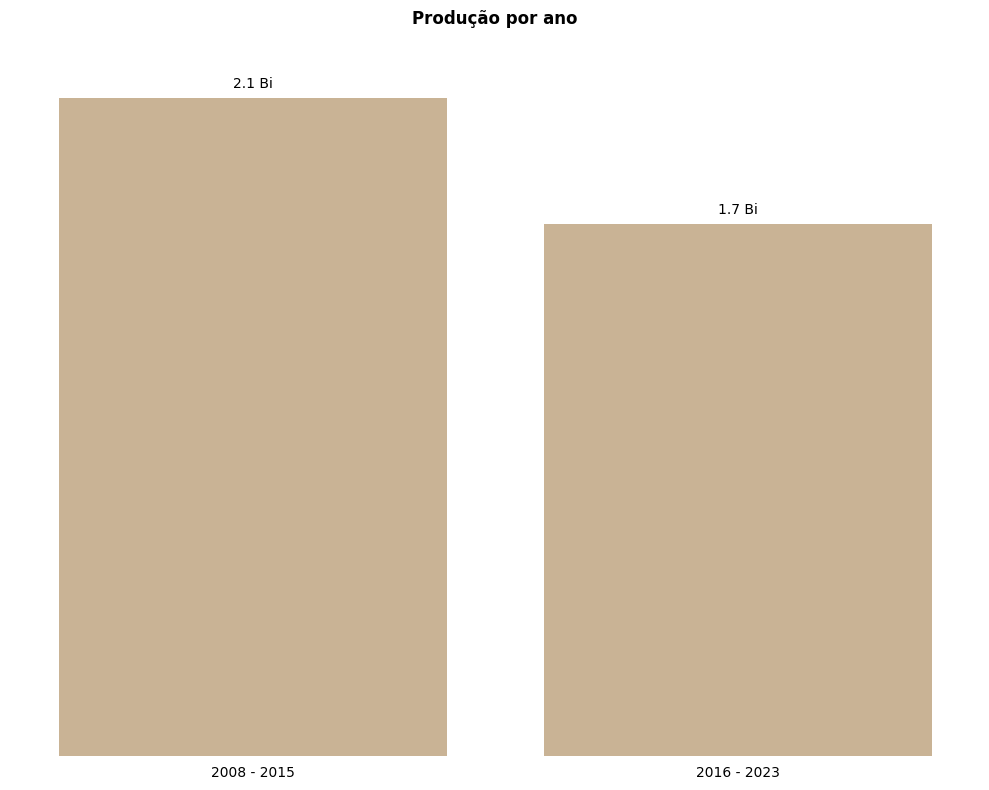

In [0]:
%python
# definindo o tamanho da figura
plt.figure(figsize=(10,8))
# criando o grafico do período
grafico_periodo = sns.barplot(data = df_intervalo , x = 'Periodo', y = 'Valor',color = 'tan')
# adicionando o rotulo de dados
for p in grafico_periodo.patches:
    grafico_periodo.annotate(f'{p.get_height():.1f} Bi',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# chamando a função que costumiza o gráfico
grafico_vertical(grafico_periodo,df_intervalo['Valor'],'Produção por ano')
# exibindo o gráfico 
plt.show()

In [0]:
%python
estados = {
    'Rio Grande do Sul': 46.97,
    'São Paulo': 8.44,
    'Pernambuco': 8.26,
    'Paraná': 4.00,
    'Bahia': 2.07,
    'Minas Gerais': 1.35,
    'Espírito Santo': 0.20,
    'Paraíba': 0.11,
    'Goiás': 0.11,
    'Distrito Federal': 0.06
}

area = pd.DataFrame(list(estados.items()), columns=['Estado', 'Area'])

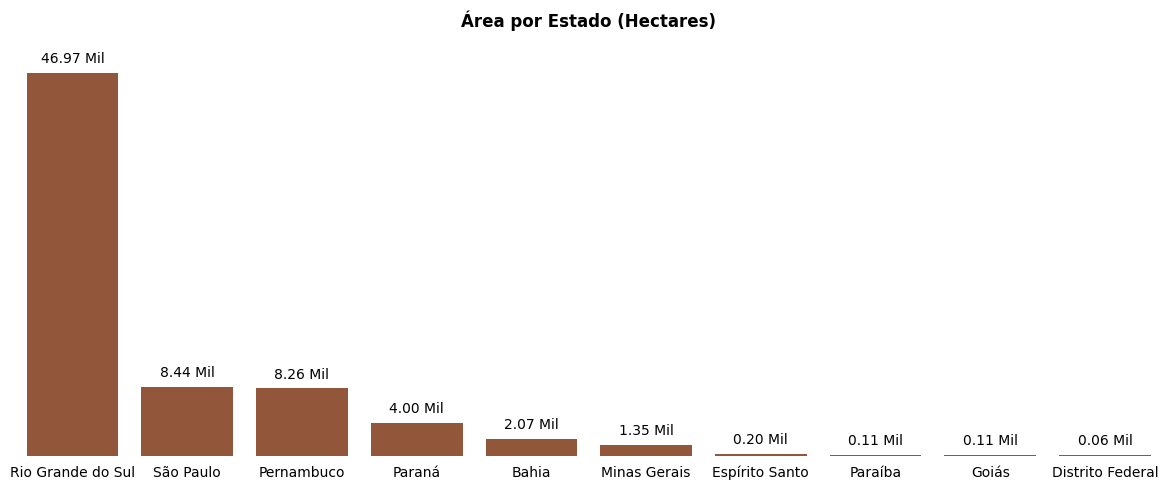

In [0]:
%python
# modificando o tamanho da figura
plt.figure(figsize=(12,5))
# criando o gráfico
grafico_area = sns.barplot(data = area , x = 'Estado' , y = 'Area', color = 'sienna')
# adicionando o rotulo de dados
for p in grafico_area.patches:
    grafico_area.annotate(f'{p.get_height():.2f} Mil',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# chamando a função que costumiza o gráfico
grafico_vertical(grafico_area,area['Area'],'Área por Estado (Hectares)')
# exibindo o grafico
plt.show()

In [0]:
%python

# Consulta Spark SQL
df_comercio = spark.sql("SELECT * FROM workspace.pos_fiap.comercio")

In [0]:
%python
# Converte Spark DataFrame para Pandas
df_comercio = df_comercio.toPandas()
comercio_vinhos  = df_comercio[(df_comercio['categoria_produto'] == 'vinho de mesa') | (df_comercio['categoria_produto'] == 'vinho fino vinífera')]


In [0]:
%python
# calculando o total comercializado de vinhos por tipo
quantidade_comercializada = comercio_vinhos.groupby('categoria_produto')['quantidade_comercializada'].sum()
# ordenando os valores em ordem decrescente
quantidade_comercializada.sort_values(ascending=False,inplace = True)
# dividindo os valores por bilhão para ficar melhor a visualização
quantidade_comercializada = quantidade_comercializada / 1_000_000_000

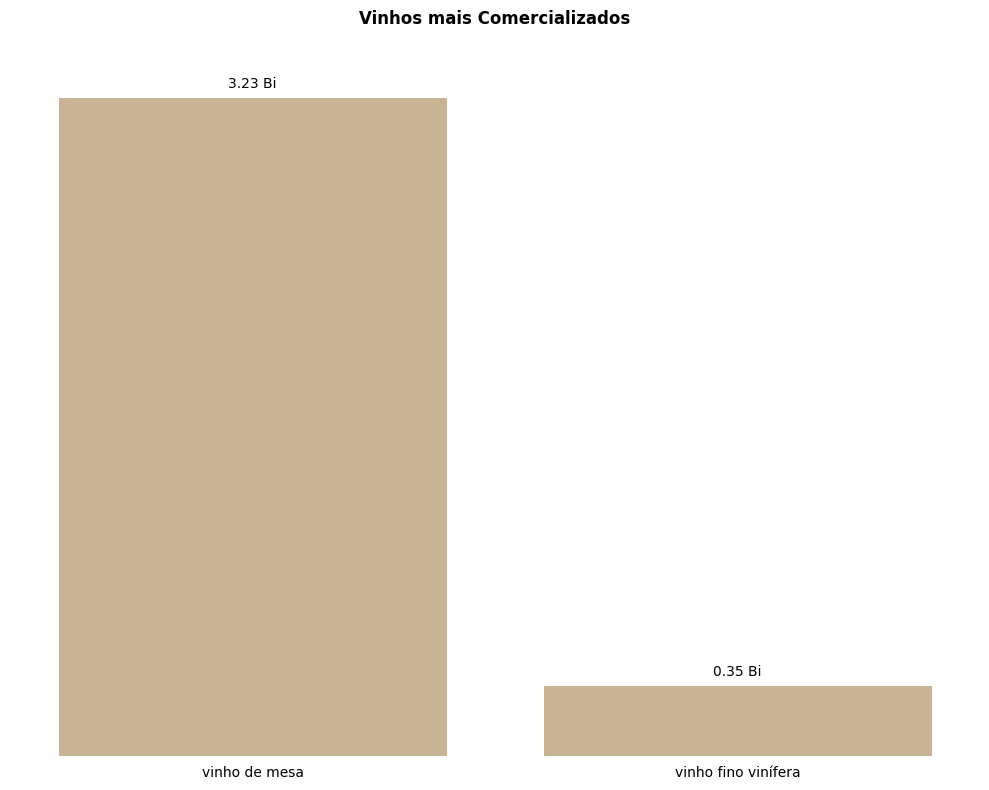

In [0]:
%python
# definindo o tamanho da figura
plt.figure(figsize=(10,8))
# criando o grafico de quantidade de vinhos produzida
ax = sns.barplot(x = quantidade_comercializada.index,y = quantidade_comercializada.values, color = 'tan')
# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f} Bi',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# chamando a função de modificar o grafico
grafico_vertical(ax,quantidade_comercializada,'Vinhos mais Comercializados')
plt.show()

In [0]:
%python
# criando uma variavel para analisar a comercialização de vinhos por ano 
comercializacao_por_ano = comercio_vinhos.groupby('ano')['quantidade_comercializada'].sum()
# dividindo o valor por milhão para facilitar a vizualização 
comercializacao_por_ano = comercializacao_por_ano / 1_000_000
#criando um dataframe 
comercializacao_por_ano = comercializacao_por_ano.reset_index()
# criando uma coluna com a Média
comercializacao_por_ano['Média'] = comercializacao_por_ano['quantidade_comercializada'].mean()
# Arredondando os valores
comercializacao_por_ano = comercializacao_por_ano.round(0)

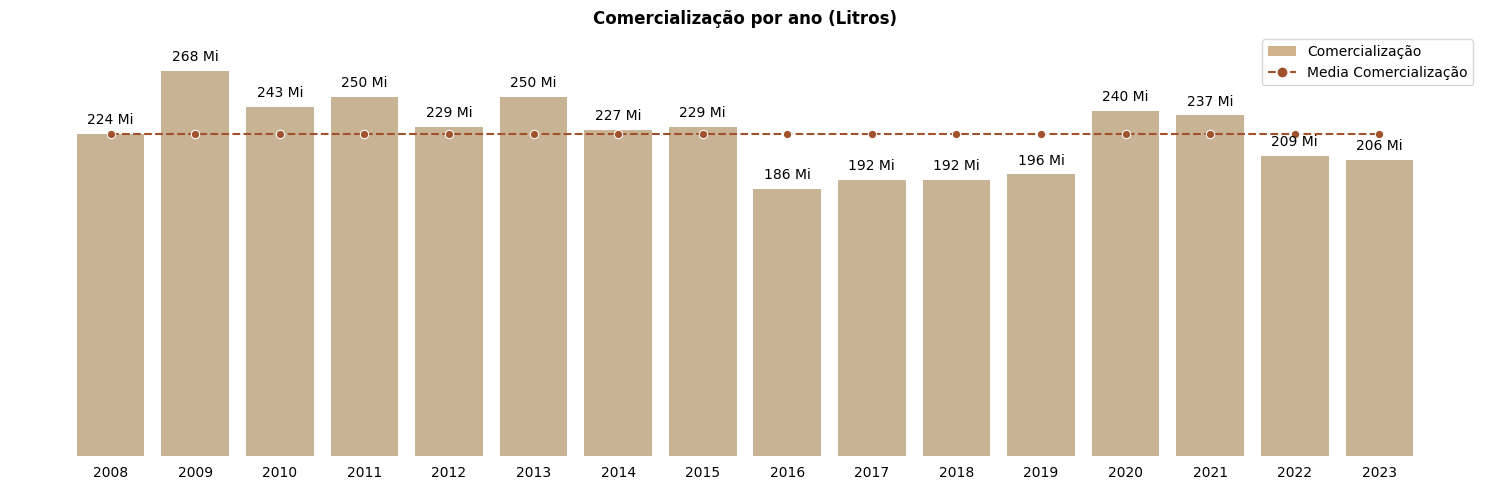

In [0]:
%python

#Ajusta type da coluna de ano
comercializacao_por_ano['ano'] = comercializacao_por_ano['ano'].astype(str)

#criando o grafico 1 
plt.figure(figsize=(15,5))
ax = sns.barplot(data = comercializacao_por_ano, x =  'ano', y = 'quantidade_comercializada' ,color = 'tan' )
# criando rotulo de dados no grafico 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f} Mi',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')

# criando o grafico 2 
sns.lineplot(data = comercializacao_por_ano, x =  'ano', y = 'Média' ,color = 'sienna', marker = 'o',linestyle = '--')


# Adicionando legendas para cada gráfico
line = plt.Line2D([], [], color='sienna', marker='o', linestyle='--', label='Media Comercialização')
bar = plt.Rectangle((0, 0), 1, 1, fc='tan', edgecolor='none', label='Comercialização')
plt.legend(handles=[bar, line], loc='upper right')
# chamando nossa função de grafico 
grafico_vertical(ax,comercializacao_por_ano['quantidade_comercializada'],'Comercialização por ano (Litros)')
plt.show()

In [0]:
%python
# calculando a produção entre 2008 e 2015
comercio_2008_2015 =  (comercio_vinhos.groupby('ano')['quantidade_comercializada'].sum()[:8].sum() / 1_000_000_000).round(1)
# calculando a produção entre 2016 e 2022
comercio_2016_2023 =  (comercio_vinhos.groupby('ano')['quantidade_comercializada'].sum()[8:].sum() / 1_000_000_000).round(1)
# criando um dataframe com esse intervalo 
intervalo = {'2008 - 2015': comercio_2008_2015, '2016 - 2023': comercio_2016_2023} 
df_intervalo_comercio = pd.DataFrame(list(intervalo.items()),columns =['Periodo','Valor'])

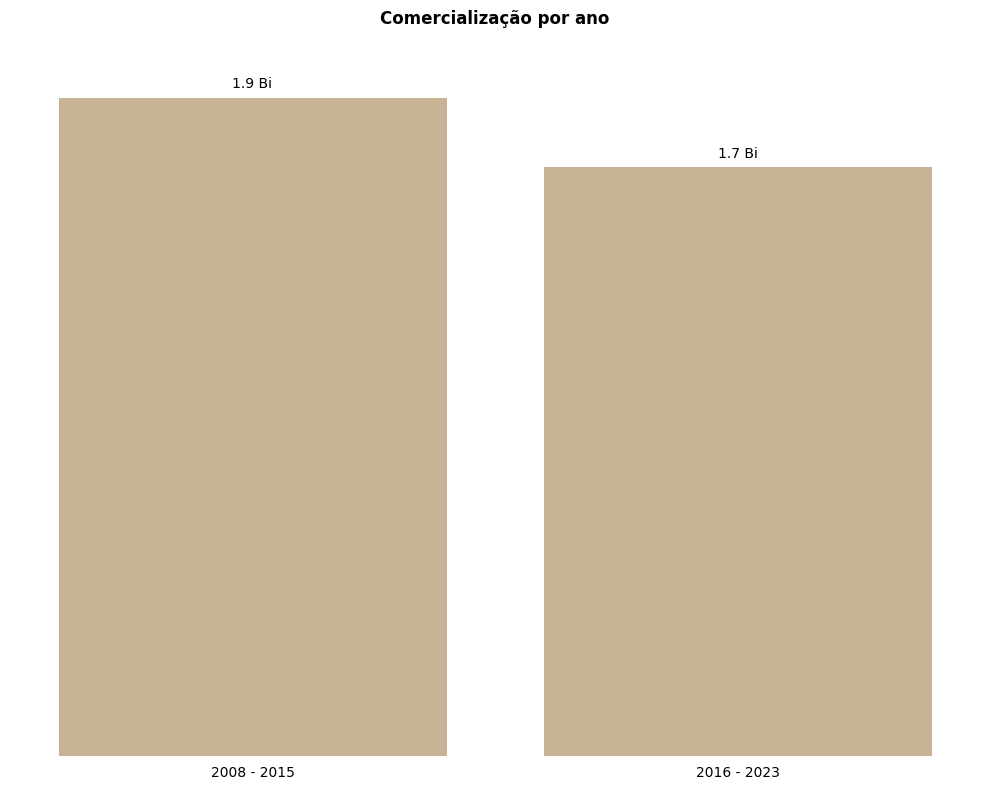

In [0]:
%python
# definindo o tamanho da figura
plt.figure(figsize=(10,8))
# criando o grafico do período
grafico_periodo = sns.barplot(data = df_intervalo_comercio , x = 'Periodo', y = 'Valor',color = 'tan')
# adicionando o rotulo de dados
for p in grafico_periodo.patches:
    grafico_periodo.annotate(f'{p.get_height():.1f} Bi',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# chamando a função que costumiza o gráfico
grafico_vertical(grafico_periodo,df_intervalo_comercio['Valor'],'Comercialização por ano')
# exibindo o gráfico 
plt.show()

In [0]:
%python

# Consulta Spark SQL
df_importacao = spark.sql("SELECT * FROM workspace.pos_fiap.importacao")
# Converte Spark DataFrame para Pandas
df_importacao = df_importacao.toPandas()

In [0]:
%python
df_importacao_filtrado  = df_importacao[(df_importacao['tipo_importacao'] == 'Vinhos')]


In [0]:
%python

# Calculando a quantidade total importada
total_importado = df_importacao_filtrado['quantidade_importada'].sum() / 1_000_000_000
# Calculando o valor total importado
total_importado_valor = df_importacao_filtrado['valor'].sum() / 1_000_000_000
# imprimindo o valor total importado
print(f'Total Importado em Dolares (US$) : {total_importado_valor.round(2)} Bilhões')
# imprimindo a quantidade total importada
print(f'Total Importado em Litros : {total_importado.round(2)} Bilhões')

Total Importado em Dolares (US$) : 5.21 Bilhões
Total Importado em Litros : 1.67 Bilhões


In [0]:
%python
# calculando as importações ao longo dos anos
importacao_anos = df_importacao_filtrado.groupby('ano')[['quantidade_importada','valor']].sum()
# dividindo tudo por 1 Milhão para facilitar a visualização no grafico 
importacao_anos = importacao_anos / 1_000_000
# Redefinindo o índice para que 'Ano' se torne uma coluna novamente
importacao_anos = importacao_anos.reset_index()

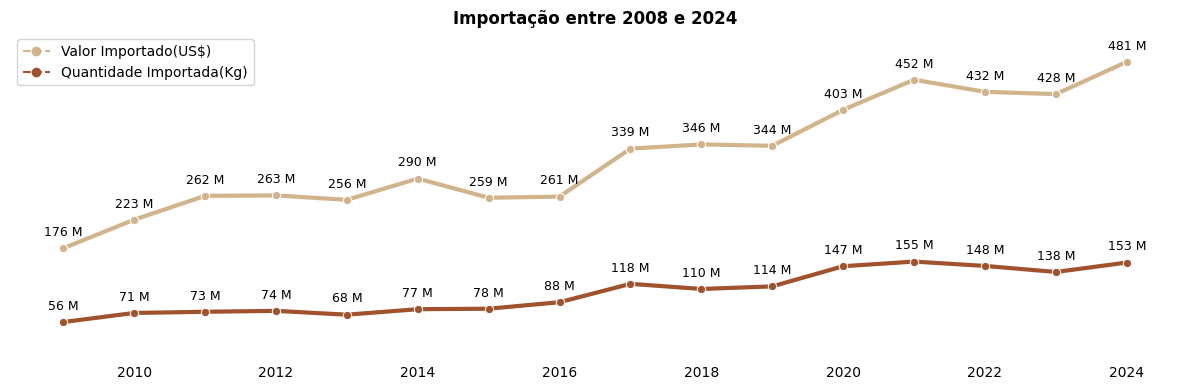

In [0]:
%python
# definindo o tamanho da figura
plt.figure(figsize=(12,4))
# Criando o gráfico de linha de valor de importação por ano
grafico_linha_importacao_valor = sns.lineplot(data=importacao_anos, x='ano', y='valor', marker='o', color='tan', linewidth=3)  # Ajustando a largura da linha

# Criando rótulo de dados no gráfico de valor
for index, row in importacao_anos.iterrows():
    plt.text(row['ano'], row['valor'] + 15, f'{row["valor"]:.0f} M', ha='center', va='bottom', fontsize=9)

# Criando o gráfico de linha de quantidade de importação por ano 
grafico_linha_importacao_quantidade = sns.lineplot(data=importacao_anos, x='ano', y='quantidade_importada', marker='o', color='sienna', linewidth=3) 

# Criando rótulo de dados no gráfico de quantidade
for index, row in importacao_anos.iterrows():
    plt.text(row['ano'], row['quantidade_importada'] + 15, f'{row["quantidade_importada"]:.0f} M', ha='center', va='bottom', fontsize=9) 

# Adicionando legendas para cada gráfico
line1 = plt.Line2D([], [], color='tan', marker='o', linestyle='--', label='Valor Importado(US$)')
line2 = plt.Line2D([], [], color='sienna', marker='o', linestyle='--', label='Quantidade Importada(Kg)')
plt.legend(handles=[line1, line2], loc='upper left')

grafico_vertical(grafico_linha_importacao_valor,importacao_anos['valor'],'Importação entre 2008 e 2024')
plt.show()

In [0]:
%python
# calculando a importacao por país
importacao_por_pais = df_importacao_filtrado.groupby('origem')[['quantidade_importada','valor']].sum()
# dividindo por 1 milhão 
importacao_por_pais = (importacao_por_pais / 1_000_000).round(1)
#ordenando por quantidade e criando um dataframe por quantidade dos top 10 países
importacao_por_pais.sort_values(by = 'quantidade_importada',ascending = False,inplace = True)
importacao_por_pais_quantidade = importacao_por_pais.head(10)
# transformando 'origem' de índice em coluna
importacao_por_pais_quantidade = importacao_por_pais_quantidade.reset_index()

#ordenando por valor e criando um dataframe por valor dos top 10 países
importacao_por_pais.sort_values(by = 'valor',ascending = False,inplace = True)
importacao_por_pais_valor = importacao_por_pais.head(10)
# transformando 'origem' de índice em coluna
importacao_por_pais_valor = importacao_por_pais_valor.reset_index()

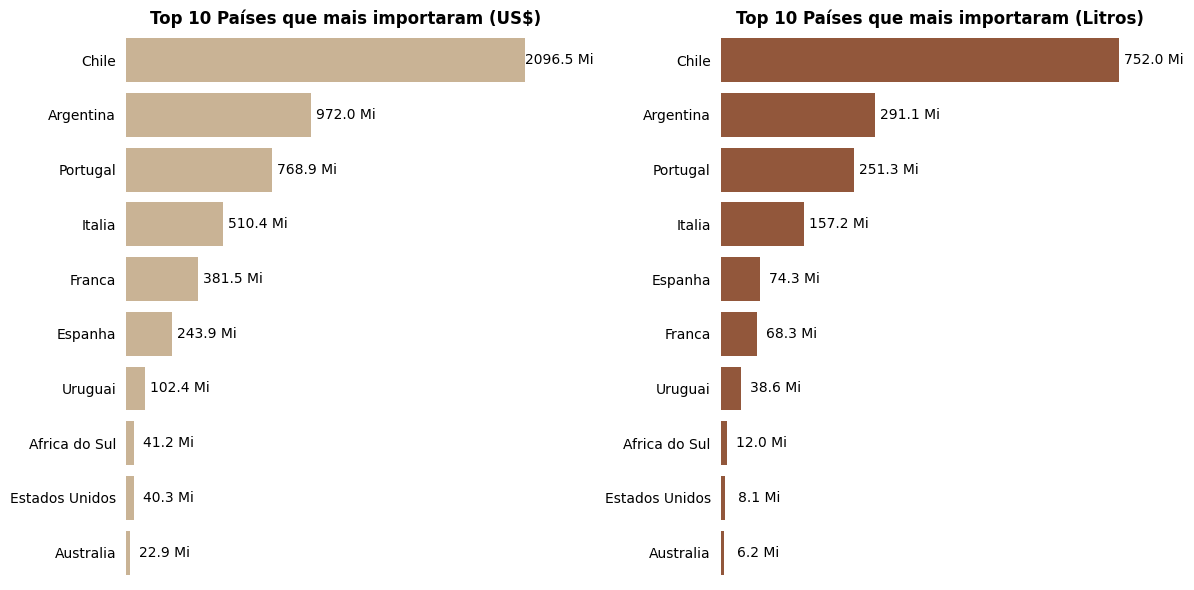

In [0]:
%python
# criando a figura com os dois graficos
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

#criando o grafico de valor importado
ax1 = sns.barplot(data = importacao_por_pais_valor,x ='valor',y = 'origem',color = 'tan',ax=ax1)
# adicionando o rotulo de dados no grafico de valor importado
for p in ax1.patches:
    width = p.get_width()
    ax1.annotate(f'{width:.1f} Mi',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')
# chamando a função de costumização para graficos na horizontal
grafico_horizontal(ax1,importacao_por_pais_valor['valor'],'Top 10 Países que mais importaram (US$)')


#criando o grafico de quantidade importada
ax2 = sns.barplot(data = importacao_por_pais_quantidade,x ='quantidade_importada',y = 'origem',color = 'sienna',ax=ax2)
# adicionando o rotulo de dados no grafico de quantidade importada
for p in ax2.patches:
    width = p.get_width()
    ax2.annotate(f'{width:.1f} Mi',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')
# chamando a função de costumização para graficos na horizontal
grafico_horizontal(ax2,importacao_por_pais_quantidade['quantidade_importada'],'Top 10 Países que mais importaram (Litros)')

In [0]:
%python
top_importacao_por_pais = importacao_por_pais.head(10)
# criando a coluna de valor do litro importado
top_importacao_por_pais['Valor do Litro Importado (US$)'] = top_importacao_por_pais['valor'] / top_importacao_por_pais['quantidade_importada']
# substituindo os valores 'inf' e '-inf' por NaN
top_importacao_por_pais.replace([np.inf, -np.inf], np.nan, inplace=True)
# substituindo os valores NaN por 0
top_importacao_por_pais.fillna(0,inplace=True)
# ordenando os valores de forma decrescente pelo valor do litro
top_importacao_por_pais.sort_values(by='Valor do Litro Importado (US$)',ascending=False,inplace=True)
# criando um dataframe com o Top10 de valor do litro importado
valor_por_litro_importado = top_importacao_por_pais.head(10)
# transformando 'origem' de índice em coluna
valor_por_litro_importado = valor_por_litro_importado.reset_index()



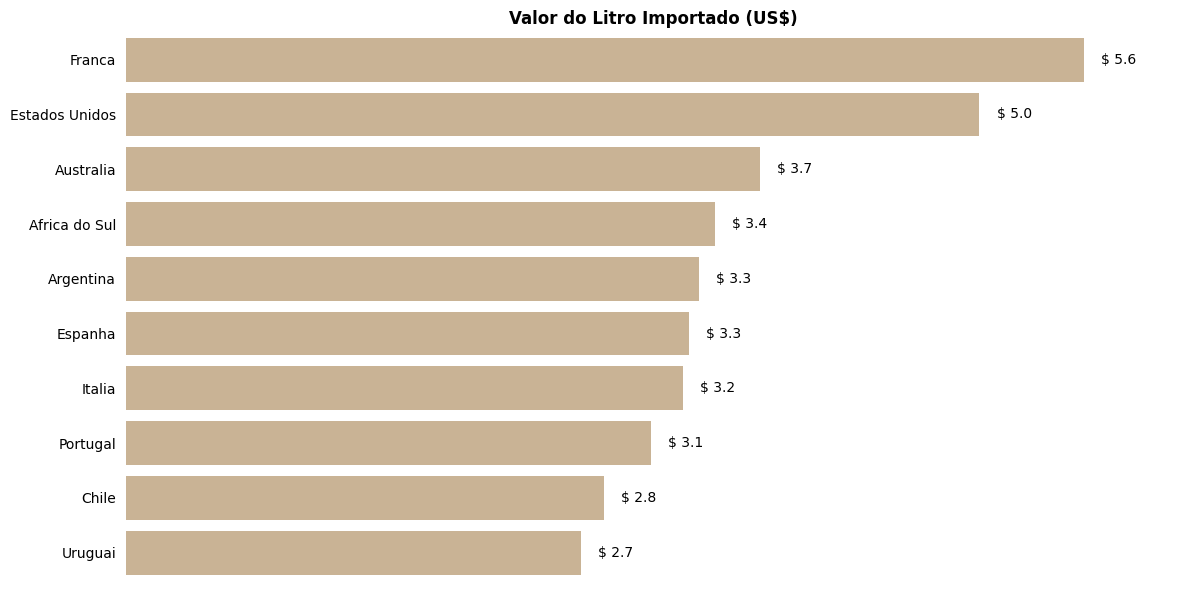

In [0]:
%python
# definindo o tamanho da figura
plt.figure(figsize=(12,6))
# criando o grafico de valor por litro importado
grafico_valor_por_litro_importado = sns.barplot(data = valor_por_litro_importado,x = 'Valor do Litro Importado (US$)',y= 'origem',color = 'tan')
# adicionando o rotulo de dados no grafico de valor por litro
for p in grafico_valor_por_litro_importado.patches:
    width = p.get_width()
    grafico_valor_por_litro_importado.annotate(f'$ {width:.1f}',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')
# chamando a função de costumização para graficos na horizontal
grafico_horizontal(grafico_valor_por_litro_importado,valor_por_litro_importado['Valor do Litro Importado (US$)'],'Valor do Litro Importado (US$)')

In [0]:
%python
#criando o dataframe de quantidade de importacao por país e por ano
quantidade_importacao = df_importacao_filtrado[['origem','ano','quantidade_importada']]
# substituindo os valores NaN por 0
quantidade_importacao.fillna(0,inplace=True)
# abrindo o dataframe por ano com o pivot
quantidade_importacao = quantidade_importacao.pivot(index='origem',columns='ano',values='quantidade_importada')


In [0]:
%python
# calculando a taxa de crescimento anual composta de importacao de vinhos para cada país(CARG Importação)
carg_quantidade_importacao = (quantidade_importacao.iloc[:, -1] / quantidade_importacao.iloc[:, 0]) ** (1 / (quantidade_importacao.shape[1] - 1)) - 1
# substituindo os valores 'inf' e '-inf' por NaN
carg_quantidade_importacao.replace([np.inf, -np.inf], np.nan, inplace=True)
# substituindo os valores NaN por 0
carg_quantidade_importacao.fillna(0,inplace=True)
# ordenando os países com maior CARG Producao
carg_quantidade_importacao = carg_quantidade_importacao.sort_values(ascending=False)
# selecionando os top 10 com maior taxa de crescimento anual composta de importação de vinho 
top10_taxa_de_importacao_quantidade = carg_quantidade_importacao.head(10)
# transformando o valor em porcentagem 
top10_taxa_de_importacao_quantidade = (top10_taxa_de_importacao_quantidade * 100).round(2)
# criando o dataframe
top10_taxa_de_importacao_quantidade = pd.DataFrame(top10_taxa_de_importacao_quantidade, columns=['Taxa de Crescimento anual de Quantidade de Vinho Importada'])
# transformando 'origem' de índice em coluna
top10_taxa_de_importacao_quantidade = top10_taxa_de_importacao_quantidade.reset_index()

In [0]:
%python
#criando o dataframe de valor de importacao por país e por ano
valor_importacao = df_importacao_filtrado[['origem','ano','valor']]
# substituindo os valores NaN por 0
valor_importacao.fillna(0,inplace=True)
# abrindo o dataframe por ano com o pivot
valor_importacao = valor_importacao.pivot(index='origem',columns='ano',values='valor')

In [0]:
%python
# calculando a taxa de crescimento anual composta de importacao de vinhos para cada país(CARG Importação)
carg_valor_importacao = (valor_importacao.iloc[:, -1] / valor_importacao.iloc[:, 0]) ** (1 / (valor_importacao.shape[1] - 1)) - 1
# substituindo os valores 'inf' e '-inf' por NaN
carg_valor_importacao.replace([np.inf, -np.inf], np.nan, inplace=True)
# substituindo os valores NaN por 0
carg_valor_importacao.fillna(0,inplace=True)
# ordenando os países com maior CARG Producao
carg_valor_importacao = carg_valor_importacao.sort_values(ascending=False)
# selecionando os top 10 com maior taxa de crescimento anual composta de importação de vinho 
top10_taxa_de_importacao_valor = carg_valor_importacao.head(10)
# transformando o valor em porcentagem 
top10_taxa_de_importacao_valor = (top10_taxa_de_importacao_valor * 100).round(2)
# criando o dataframe
top10_taxa_de_importacao_valor = pd.DataFrame(top10_taxa_de_importacao_valor, columns=['Taxa de Crescimento anual de Valor de Vinho Importada'])
# transformando 'origem' de índice em coluna
top10_taxa_de_importacao_valor = top10_taxa_de_importacao_valor.reset_index()

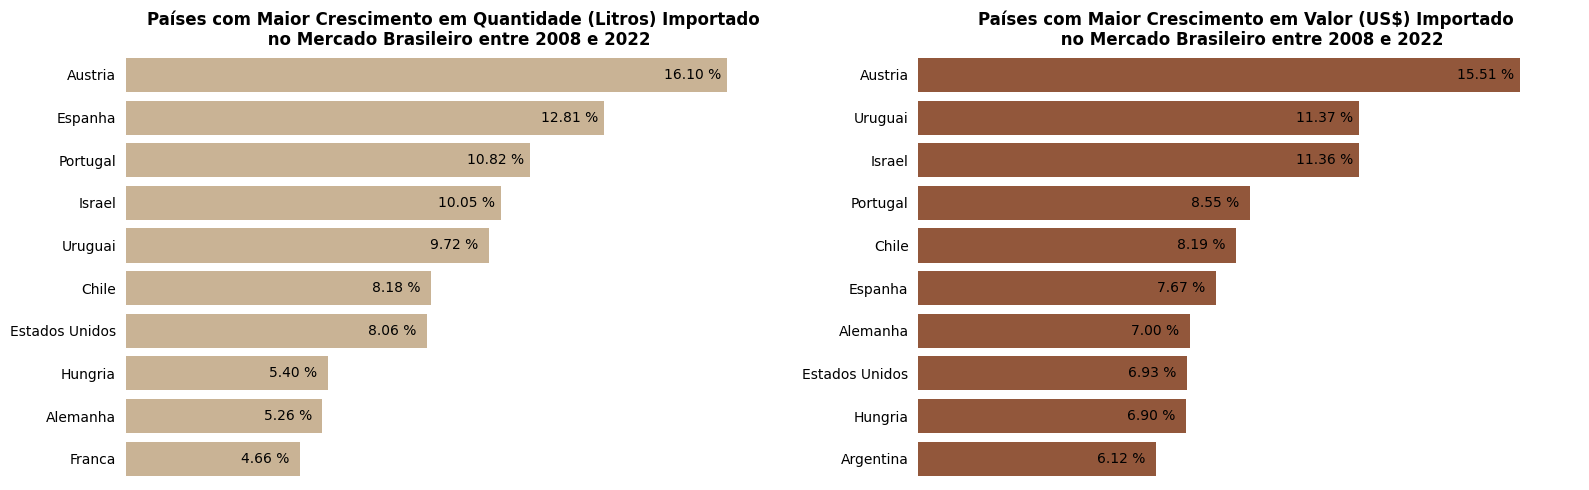

In [0]:
%python
# criando a figura com os dois graficos
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))

#criando o grafico do top 10 com maior crescimento de importação por quantidade importada
ax1 = sns.barplot(data = top10_taxa_de_importacao_quantidade,x ='Taxa de Crescimento anual de Quantidade de Vinho Importada',y = 'origem',color = 'tan',ax=ax1)
# adicionando o rotulo de dados no grafico de valor importado
for p in ax1.patches:
    width = p.get_width()
    ax1.annotate(f'{width:.2f} %',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(-25, 0),
                 textcoords='offset points')
# chamando a função de costumização para graficos na horizontal
grafico_horizontal(ax1,top10_taxa_de_importacao_quantidade['Taxa de Crescimento anual de Quantidade de Vinho Importada'],'Países com Maior Crescimento em Quantidade (Litros) Importado \n no Mercado Brasileiro entre 2008 e 2022')


#criando o grafico de quantidade importada
ax2 = sns.barplot(data = top10_taxa_de_importacao_valor,x ='Taxa de Crescimento anual de Valor de Vinho Importada',y = 'origem',color = 'sienna',ax=ax2)
# adicionando o rotulo de dados no grafico de quantidade importada
for p in ax2.patches:
    width = p.get_width()
    ax2.annotate(f'{width:.2f} %',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(-25, 0),
                 textcoords='offset points')
# chamando a função de costumização para graficos na horizontal
grafico_horizontal(ax2,top10_taxa_de_importacao_valor['Taxa de Crescimento anual de Valor de Vinho Importada'],'Países com Maior Crescimento em Valor (US$) Importado \n no Mercado Brasileiro entre 2008 e 2022')


In [0]:
%python

# Consulta Spark SQL
df_exportacao = spark.sql("SELECT * FROM workspace.pos_fiap.exportacao")
# Converte Spark DataFrame para Pandas
df_exportacao = df_exportacao.toPandas()


df_exportacao_filtrado  = df_exportacao[(df_exportacao['tipo_exportacao'] == 'Vinhos')]

In [0]:
%python
# definindo o index como país para filtrar as colunas de 2008 a 2022
exportacao = df_exportacao_filtrado.set_index('destino')


In [0]:
%python
exportacao_total_anos = df_exportacao_filtrado.groupby('ano')[['quantidade_exportada','valor']].sum()
exportacao_total_anos = exportacao_total_anos / 1_000_000
exportacao_total_anos.reset_index(inplace=True)

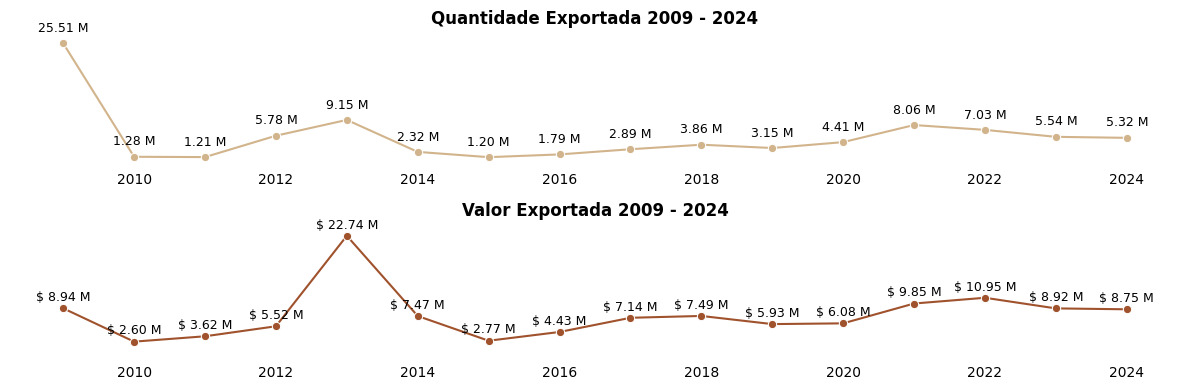

In [0]:
%python
# criando a figura com os dois graficos
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,4))
#criando Exportação por quantidade 
grafico_exportacao_linha_quantidade = sns.lineplot(data = exportacao_total_anos, x = 'ano',y ='quantidade_exportada',ax = ax1,color = 'tan',marker = 'o')
# Criando rótulo de dados no gráfico de linha de quantidade
for index, row in exportacao_total_anos.iterrows():
    ax1.text(row['ano'], row['quantidade_exportada'] + 2, f'{row["quantidade_exportada"]:.2f} M', 
             ha='center', va='bottom', fontsize=9)
# chamando a função de costumização do grafico
grafico_vertical(grafico_exportacao_linha_quantidade,exportacao_total_anos['quantidade_exportada'],'Quantidade Exportada 2009 - 2024')

#criando Exportação por quantidade 
grafico_exportacao_linha_valor = sns.lineplot(data = exportacao_total_anos, x = 'ano',y ='valor',ax = ax2,color = 'sienna',marker = 'o')
# Criando rótulo de dados no gráfico de linha de quantidade
for index, row in exportacao_total_anos.iterrows():
    ax2.text(row['ano'], row['valor'] + 1, f'$ {row["valor"]:.2f} M', 
             ha='center', va='bottom', fontsize=9)
# chamando a função de costumização do grafico
grafico_vertical(grafico_exportacao_linha_valor,exportacao_total_anos['valor'],'Valor Exportada 2009 - 2024')


In [0]:
%python

# juntando os dataframes
importacao_exportacao = pd.merge(df_importacao_filtrado,df_exportacao_filtrado,on =['origem','ano'])

In [0]:
%python
# criando o dataframe da exportação apenas da Rússia 
exportacao_russia = importacao_exportacao[importacao_exportacao['destino_y'] == 'Russia']
# eliminando coluna de importação
exportacao_russia.drop(['quantidade_importada','valor_x'],axis=1,inplace=True)
# dividindo os valores por 1 milhão 
exportacao_russia['quantidade_exportada'] = exportacao_russia['quantidade_exportada'] / 1_000_000
exportacao_russia['valor_y'] = exportacao_russia['valor_y'] / 1_000_000


In [0]:
%python
print(exportacao_russia['ano'].unique())


[]


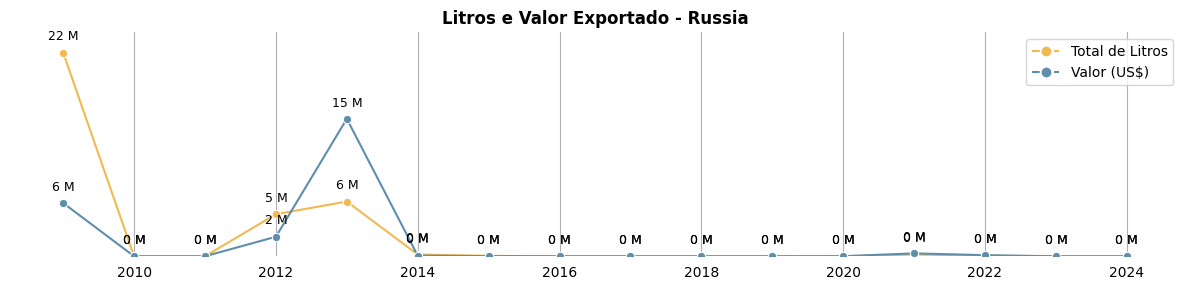

In [0]:
%python
# criando a figura
plt.figure(figsize = (12,3))
# criando o grafico de quantidade
quantidade_russia = sns.lineplot(data = exportacao_russia, x = 'ano' ,y = 'quantidade_exportada', color= '#F1B951',marker='o')

# Criando rótulo de dados no gráfico de quantidade da Rússia
for index, row in exportacao_russia.iterrows():
    plt.text(row['ano'], row['quantidade_exportada'] + 1, f'{row["quantidade_exportada"]:.0f} M', ha='center', va='bottom', fontsize=9) 


# criando o grafico de valor
valor_russia = sns.lineplot(data = exportacao_russia, x = 'ano' ,y = 'valor_y', color= '#5E8EAC',marker='o')

# Criando rótulo de dados no gráfico de valor da Rússia
for index, row in exportacao_russia.iterrows():
    plt.text(row['ano'], row['valor_y'] + 1, f'{row["valor_y"]:.0f} M', ha='center', va='bottom', fontsize=9)

# Adicionando legendas para cada gráfico
russia_quantidade = plt.Line2D([], [], color='#F1B951', marker='o', linestyle='--', label='Total de Litros')
russia_valor = plt.Line2D([], [], color='#5E8EAC', marker='o', linestyle='--', label='Valor (US$)')
plt.legend(handles=[russia_quantidade, russia_valor], loc='upper right') 
# chamando a função de costumização de grafico
grafico_vertical(quantidade_russia,exportacao_russia['quantidade_exportada'],'Litros e Valor Exportado - Russia')
plt.grid()

In [0]:
%python
# calculando a exportacao por país
exportacao_por_pais = importacao_exportacao.groupby('destino_y')[['quantidade_exportada','valor_y']].sum()
# dividindo por 1 milhão 
exportacao_por_pais = (exportacao_por_pais / 1_000_000).round(1)
#ordenando por quantidade e criando um dataframe por quantidade dos top 10 países
exportacao_por_pais.sort_values(by = 'quantidade_exportada',ascending = False,inplace = True)
exportacao_por_pais_quantidade = exportacao_por_pais.head(10)
exportacao_por_pais_quantidade.reset_index(inplace=True)
#ordenando por valor e criando um dataframe por valor dos top 10 países
exportacao_por_pais.sort_values(by = 'valor_y',ascending = False,inplace = True)
exportacao_por_pais_valor = exportacao_por_pais.head(10)
exportacao_por_pais_valor.reset_index(inplace=True)

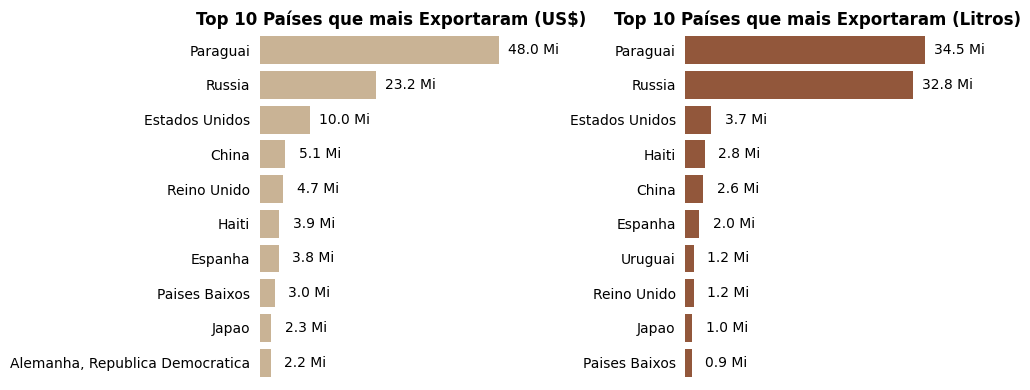

In [0]:
%python
# criando a figura com os dois graficos
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

#criando o grafico de valor exportado
ax1 = sns.barplot(data = exportacao_por_pais_valor,x ='valor_y',y = 'destino_y',color = 'tan',ax=ax1)
# adicionando o rotulo de dados no grafico de valor exportado
for p in ax1.patches:
    width = p.get_width()
    ax1.annotate(f'{width:.1f} Mi',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')
# chamando a função de costumização para graficos na horizontal
grafico_horizontal(ax1,exportacao_por_pais_valor['valor_y'],'Top 10 Países que mais Exportaram (US$)')


#criando o grafico de quantidade exportada
ax2 = sns.barplot(data = exportacao_por_pais_quantidade,x ='quantidade_exportada',y = 'destino_y',color = 'sienna',ax=ax2)
# adicionando o rotulo de dados no grafico de quantidade exportada
for p in ax2.patches:
    width = p.get_width()
    ax2.annotate(f'{width:.1f} Mi',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')
# chamando a função de costumização para graficos na horizontal
grafico_horizontal(ax2,exportacao_por_pais_quantidade['quantidade_exportada'],'Top 10 Países que mais Exportaram (Litros)')

In [0]:
%python
# calculando a exportacao por país para obter valor por litro
valor_por_litro_exportado = importacao_exportacao.groupby('destino_y')[['quantidade_exportada','valor_y']].sum()
#ordenando por valor exportado
valor_por_litro_exportado.sort_values(by='valor_y',ascending=False,inplace=True)
# pegando o top 10 de valor exportado
valor_por_litro_exportado = valor_por_litro_exportado.head(10)
valor_por_litro_exportado.reset_index(inplace=True)
#criando a coluna de valor do litro exportado
valor_por_litro_exportado['Valor do Litro Exportado(US$)'] = valor_por_litro_exportado['valor_y'] / valor_por_litro_exportado['quantidade_exportada']
# ordenando por valor do litro exportado
valor_por_litro_exportado.sort_values(by='Valor do Litro Exportado(US$)',ascending=False,inplace=True)

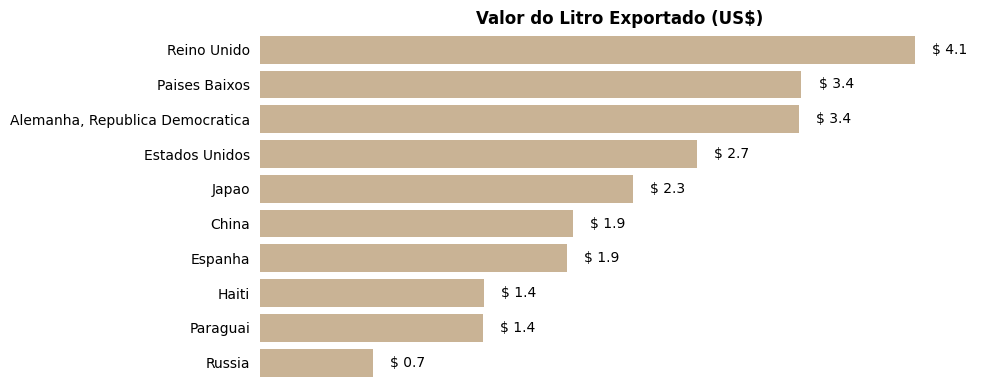

In [0]:
%python
# definindo o tamanho da figura
plt.figure(figsize=(10,4))
# criando o grafico de valor por litro exportado
grafico_valor_por_litro_exportado = sns.barplot(data = valor_por_litro_exportado,x = 'Valor do Litro Exportado(US$)',y= 'destino_y',color = 'tan')
# adicionando o rotulo de dados no grafico de valor por litro
for p in grafico_valor_por_litro_exportado.patches:
    width = p.get_width()
    grafico_valor_por_litro_exportado.annotate(f'$ {width:.1f}',
                 (p.get_x() + width, p.get_y() + p.get_height() / 2),
                 ha='center', va='center', xytext=(25, 0),
                 textcoords='offset points')
# chamando a função de costumização para graficos na horizontal
grafico_horizontal(grafico_valor_por_litro_exportado,valor_por_litro_exportado['Valor do Litro Exportado(US$)'],'Valor do Litro Exportado (US$)')


In [0]:
%python
# calculando a variação da quantidade exportada com relaão ao ano anterior
exportacao_total_anos['Variação'] = exportacao_total_anos['quantidade_exportada'].pct_change() * 100
exportacao_total_anos.fillna(0,inplace=True)

In [0]:
%python
# criando a tabela de exportacao
top_exportacao_brasil = exportacao_por_pais
# adicionando a escala de milhar nas colunas 
top_exportacao_brasil['Quantidade Exportada(Kg)'] = top_exportacao_brasil['quantidade_exportada'].apply(lambda x: f'{x :.2f} Mi')
top_exportacao_brasil['Valor Exportado(US$)'] = top_exportacao_brasil['valor_y'].apply(lambda x: f'{x :.2f} Mi')
#resetando o index 
top_exportacao_brasil.reset_index(inplace=True)
# adicionando a coluna País de Origem
top_exportacao_brasil['País de Origem'] = 'Brasil'
# alterando a ordem das colunas 
top_exportacao_brasil = top_exportacao_brasil.reindex(columns = ['País de Origem','destino_y','quantidade_exportada','valor_y'])
# renomeando as colunas
top_exportacao_brasil.columns = [['País de Origem','País Destino','Quantidade Exportada(L)','Valor Exportado(US$)']]
top_exportacao_brasil.head(10)

,País de Origem,País Destino,Quantidade Exportada(L),Valor Exportado(US$)
0,Brasil,Paraguai,34.5,48.0
1,Brasil,Russia,32.8,23.2
2,Brasil,Estados Unidos,3.7,10.0
3,Brasil,China,2.6,5.1
4,Brasil,Reino Unido,1.2,4.7
5,Brasil,Haiti,2.8,3.9
6,Brasil,Espanha,2.0,3.8
7,Brasil,Paises Baixos,0.9,3.0
8,Brasil,Japao,1.0,2.3
9,Brasil,"Alemanha, Republica Democratica",0.7,2.2


In [0]:

%python
# criando a lista com os ultimos 5 anos 
lista_anos = [2020,2021,2022,2023,2024]
# filtrando os ultimos 5 anos 
ultimos_cinco_anos = importacao_exportacao[importacao_exportacao['ano'].isin(lista_anos)]

In [0]:
%python
# criando a lista com os ultimos 5 anos 
lista_anos = [2020,2021,2022,2023,2024]
# filtrando os ultimos 5 anos 
ultimos_cinco_anos = importacao_exportacao[importacao_exportacao['ano'].isin(lista_anos)]
# agrupando o valor total dos ultimos 5 anos por país
agrupado_ultimos_cinco_anos = ultimos_cinco_anos.groupby('destino_y')[['quantidade_exportada','valor_y']].sum()
# ordenando os top 5 países que mais exportaram para o Brasil nos ultimos 5 anos 
agrupado_ultimos_cinco_anos = agrupado_ultimos_cinco_anos.sort_values(by = 'quantidade_exportada',ascending=False).head()
agrupado_ultimos_cinco_anos

,quantidade_exportada,valor_y
destino_y,,
Paraguai,22383856,28857018
Haiti,2633345,3628166
Estados Unidos,1171885,2340055
Uruguai,1136713,1663805
China,397680,1397454


In [0]:
%python
#lista dos paises que mais exportaram
lista_de_paises_5_anos = agrupado_ultimos_cinco_anos.index.tolist()
# filtrando apenas os top 5 paises que mais exportaram
top5_ultimos_cinco_anos = importacao_exportacao[importacao_exportacao['destino_y'].isin(lista_de_paises_5_anos)]
# filtrando apenas os ultimos 5 anos
top5_ultimos_cinco_anos = top5_ultimos_cinco_anos[top5_ultimos_cinco_anos['ano'].isin(lista_anos)]

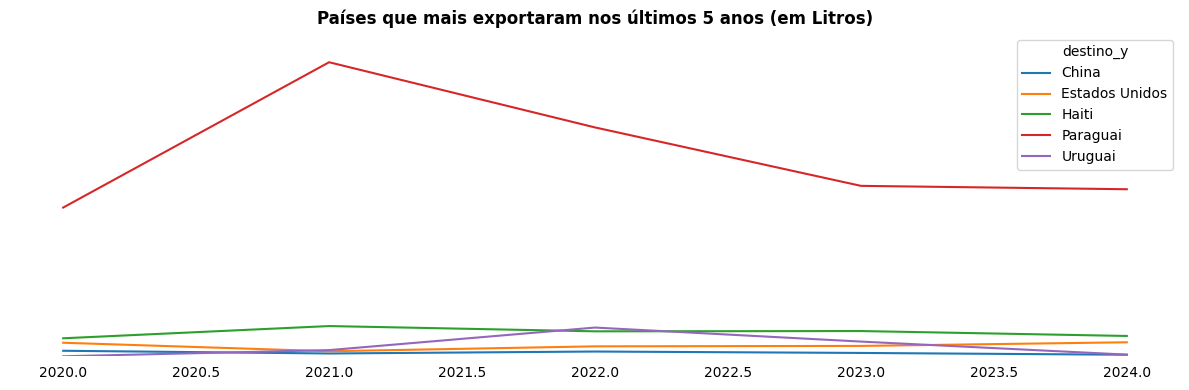

In [0]:
%python
# criando a figura
plt.figure(figsize=(12,4))
# criando o grafico
grafico_ultimos_5_anos = sns.lineplot(data = top5_ultimos_cinco_anos,x = 'ano',y='quantidade_exportada',hue='destino_y')
# chamando a função de costumização
grafico_vertical(grafico_ultimos_5_anos,top5_ultimos_cinco_anos['quantidade_exportada'],'Países que mais exportaram nos últimos 5 anos (em Litros)')

In [0]:
%python
# removendo as duas ultimas linhas do dataframe que não correspondem a dados do dataframe 
mercado = mercado.iloc[:-2]
mercado.head()

,Continent,Region/Country,Product,Variable,Year,Unit,Quantity
0,Asia,Afghanistan,Wine,Consumption,2008.0,1000 hl,1.0
1,Asia,Afghanistan,Wine,Imports,2008.0,1000 hl,1.0
2,Asia,Afghanistan,Wine,Production,2008.0,1000 hl,0.0
3,Asia,Afghanistan,Wine,Consumption,2009.0,1000 hl,3.0
4,Asia,Afghanistan,Wine,Imports,2009.0,1000 hl,3.0


In [0]:
# alterando o nome das colunas
mercado.columns = ['Continente', 'País', 'Produto', 'Categoria', 'Ano', 'Unidade',
       'Quantidade']
# Visualizando o tipo de dados de cada coluna
mercado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11767 entries, 0 to 11766
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Continente  11767 non-null  object 
 1   País        11767 non-null  object 
 2   Produto     11767 non-null  object 
 3   Categoria   11767 non-null  object 
 4   Ano         11767 non-null  float64
 5   Unidade     11767 non-null  object 
 6   Quantidade  11767 non-null  float64
dtypes: float64(2), object(5)
memory usage: 643.6+ KB


In [0]:
%python
# Vizualizando o tipo de produto presente na base 
mercado['Produto'].unique()

array(['Wine'], dtype=object)

In [0]:
%python
# removendo as duas ultimas linhas do dataframe que não correspondem a dados do dataframe 
mercado = mercado.iloc[:-2]

In [0]:
%python
# Visualizar o tamanho do dataframe Mercado Global de Vinhos
print(f"Linhas da tabela Mercado Global de Vinhos: {mercado.shape[0]}")
print(f"Colunas da tabela Mercado Global de Vinhos: {mercado.shape[1]}")
# Visualizar o ano inicial e o ano final da base 
print(f"O primeiro ano registrado na tabela é : {mercado['Ano'].min()}")
print(f"O último ano registrado na tabela é : {mercado['Ano'].max()}")


Linhas da tabela Mercado Global de Vinhos: 11765
Colunas da tabela Mercado Global de Vinhos: 7
O primeiro ano registrado na tabela é : 2008.0
O último ano registrado na tabela é : 2022.0


In [0]:
%python
# Excluindo a coluna Produto pois toda a tabela se trata apenas de um produto Vinho 
mercado.drop('Produto',axis = 1,inplace = True)
# visuzalizando os dados referentes a categoria 
mercado['Categoria'].unique()


array(['Consumption', 'Imports', 'Production', 'Exports'], dtype=object)

In [0]:
%python
# traduzindo para o portugues a coluna categoria
mercado['Categoria'].replace({'Consumption': 'Consumo',
                               'Imports': 'Importação', 
                               'Production': 'Produção',
                                'Exports': 'Exportação'},
                                inplace=True)
mercado['Categoria'].unique()

array(['Consumo', 'Importação', 'Produção', 'Exportação'], dtype=object)

In [0]:
%python
# Traduzindo para o portugues a coluna de continente
mercado['Continente'].replace('Europe','Europa', inplace=True)
mercado['Continente'].unique()


array(['Asia', 'Europa', 'Africa', 'Oceania', 'America', 'Global'],
      dtype=object)

In [0]:
%python
# Corrigindo a escrita da coluna Ano
mercado['Ano'] = mercado['Ano'].astype(str)
mercado['Ano'] = mercado['Ano'].str[:-2]
mercado['Ano'].unique()

array(['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype=object)

In [0]:
%python
# a coluna Unidade esta em hectolitro ao inves de litro primeiro vamos converter para litro
mercado['Unidade'].unique()


array(['1000\xa0hl'], dtype=object)

In [0]:
%python
# convertendo para litro
mercado['Unidade'] = 100_000
# agora vamos multiplicar a coluna unidade por quantidade para saber o valor em litro 
mercado['Quantidade'] = mercado['Unidade'] * mercado['Quantidade']
# podemos apagar a coluna Unidade e deixar somente a coluna Quantidade
mercado.drop('Unidade',axis= 1,inplace = True)
# Renomeando a coluna Quantidade 
mercado.rename(columns={'Quantidade':'Quantidade(L)'},inplace=True)

In [0]:
%python
# Somando os dados dos 15 anos por país
total_por_pais = mercado.groupby(['Continente','País','Categoria'])['Quantidade(L)'].sum().reset_index()
total_por_pais.head(10)

,Continente,País,Categoria,Quantidade(L)
0,Africa,Algeria,Consumo,4.328000e+08
1,Africa,Algeria,Exportação,6.600000e+06
2,Africa,Algeria,Importação,9.850000e+07
3,Africa,Algeria,Produção,4.513000e+08
4,Africa,Angola,Consumo,1.197200e+09
5,Africa,Angola,Exportação,1.290000e+07
6,Africa,Angola,Importação,1.229100e+09
7,Africa,Angola,Produção,0.000000e+00
8,Africa,Benin,Consumo,5.630000e+07
9,Africa,Benin,Exportação,4.300000e+06


In [0]:
%python
# Abrindo os dados para que cada categoria vire uma coluna 
total_aberto = total_por_pais.pivot(index='País',columns='Categoria',values='Quantidade(L)')
total_aberto.head()

Categoria,Consumo,Exportação,Importação,Produção
País,,,,
Afghanistan,1800000.0,NaN,1700000.0,0.0
Albania,335200000.0,0.0,58200000.0,280800000.0
Algeria,432800000.0,6600000.0,98500000.0,451300000.0
American Samoa,400000.0,NaN,200000.0,0.0
Andorra,NaN,NaN,NaN,0.0


In [0]:
%python
# substituindo os valores nulos por 0
total_aberto.fillna(0,inplace=True)
# Resetando o index da tabela 
total_aberto = total_aberto.reset_index()

In [0]:
%python
# Ordenando os dados do Mercado Global de Vinhos Total do maior para o menor pela importação
total_aberto.sort_values(by = 'Importação',ascending=False,inplace = True)
# Retirnado a primeira linha que é referente ao total mundial 
total_aberto = total_aberto.iloc[1:]
# pegando apenas os top 40 que mais importaram vinho nos ultimos 15 anos 
total_aberto = total_aberto[:40]


total_aberto.reset_index(inplace=True)

In [0]:
%python
# Lista dos 40 países que mais importaram vinhos nos ultimos anos 
lista_de_paises = total_aberto['País'].unique()
print(lista_de_paises)

['Germany' 'United Kingdom' 'United States of America' 'France' 'Russia'
 'China, mainland' 'Netherlands' 'Canada' 'Belgium' 'Japan' 'Italy'
 'Sweden' 'Portugal' 'Denmark' 'Switzerland' 'Czech Republic' 'Poland'
 'Brazil' 'Australia' 'Norway' 'Lithuania' 'Angola' 'Ireland' 'Austria'
 'Spain' 'Finland' 'Slovakia' 'Latvia' 'Mexico' 'Belarus'
 'China, Hong Kong SAR' 'Romania' 'Korea (the Republic of)' 'Ukraine'
 'New Zealand' "Côte d'Ivoire" 'United Arab Emirates' 'Namibia'
 'Singapore' 'Nigeria']


In [0]:
%python
# criando um dataframe com as categorias em uma coluna apenas com os 40 países que mais importaram 
mercado_top40 = mercado[mercado['País'].isin(lista_de_paises)]
mercado_top40.head()

,Continente,País,Categoria,Ano,Quantidade(L)
225,Africa,Angola,Consumo,2008,116000000.0
226,Africa,Angola,Exportação,2008,0.0
227,Africa,Angola,Importação,2008,116000000.0
228,Africa,Angola,Produção,2008,0.0
229,Africa,Angola,Consumo,2009,79800000.0


In [0]:
%python
# Dicionário de tradução dos países para o português
paises_traduzidos = {
    'Angola': 'Angola', 'Australia': 'Austrália', 'Austria': 'Áustria', 'Belarus': 'Bielorrússia', 'Belgium': 'Bélgica',
    'Brazil': 'Brasil', 'Canada': 'Canadá', 'China, Hong Kong SAR': 'Hong Kong', 'China, mainland': 'China', "Côte d'Ivoire": 'Costa do Marfim',
    'Czech Republic': 'República Tcheca', 'Denmark': 'Dinamarca', 'Finland': 'Finlândia', 'France': 'França', 'Germany': 'Alemanha',
    'Ireland': 'Irlanda', 'Italy': 'Itália', 'Japan': 'Japão', 'Korea (the Republic of)': 'Coreia do Sul', 'Latvia': 'Letônia',
    'Lithuania': 'Lituânia', 'Mexico': 'México', 'Namibia': 'Namíbia', 'Netherlands': 'Países Baixos', 'New Zealand': 'Nova Zelândia',
    'Norway': 'Noruega', 'Paraguay': 'Paraguai', 'Poland': 'Polônia', 'Portugal': 'Portugal', 'Romania': 'Romênia', 'Russia': 'Rússia',
    'Singapore': 'Singapura', 'Slovakia': 'Eslováquia', 'Spain': 'Espanha', 'Sweden': 'Suécia', 'Switzerland': 'Suíça', 'Ukraine': 'Ucrânia',
    'United Arab Emirates': 'Emirados Árabes Unidos', 'United Kingdom': 'Reino Unido', 'United States of America': 'Estados Unidos',
    'Nigeria': 'Nigéria' 
}
# Substituindo o nome dos países 
mercado_top40['País'] = mercado_top40['País'].replace(paises_traduzidos)
# excluindo o Brasil da Lista de Países 
mercado_top40 = mercado_top40[mercado_top40['País'] != 'Brasil']
# verificando se foi alterado o nome dos países
mercado_top40['País'].unique()

array(['Angola', 'Austrália', 'Áustria', 'Bielorrússia', 'Bélgica',
       'Canadá', 'Hong Kong', 'China', 'Costa do Marfim',
       'República Tcheca', 'Dinamarca', 'Finlândia', 'França', 'Alemanha',
       'Irlanda', 'Itália', 'Japão', 'Coreia do Sul', 'Letônia',
       'Lituânia', 'México', 'Namíbia', 'Países Baixos', 'Nova Zelândia',
       'Nigéria', 'Noruega', 'Polônia', 'Portugal', 'Romênia', 'Rússia',
       'Singapura', 'Eslováquia', 'Espanha', 'Suécia', 'Suíça', 'Ucrânia',
       'Emirados Árabes Unidos', 'Reino Unido', 'Estados Unidos'],
      dtype=object)

In [0]:
%python
# Substituindo o nome dos países no dataframe aberto 
total_aberto['País'] = total_aberto['País'].replace(paises_traduzidos)
# excluindo o Brasil da Lista de Países 
total_aberto = total_aberto[total_aberto['País'] != 'Brasil']
total_aberto

Categoria,index,País,Consumo,Exportação,Importação,Produção
0,76,Alemanha,3.010620e+10,5.660100e+09,2.226990e+10,1.314530e+10
1,209,Reino Unido,1.951400e+10,1.188500e+09,1.977290e+10,6.980000e+07
2,210,Estados Unidos,4.649480e+10,5.712700e+09,1.691680e+10,3.479240e+10
3,70,França,4.091480e+10,2.113370e+10,9.762800e+09,6.657170e+10
4,165,Rússia,1.504420e+10,3.640000e+07,6.605900e+09,7.741200e+09
5,43,China,2.358440e+10,6.410000e+07,6.581600e+09,1.675930e+10
6,140,Países Baixos,5.273900e+09,7.934000e+08,6.057700e+09,8.000000e+06
7,35,Canadá,7.322800e+09,1.247500e+09,5.864200e+09,9.325000e+08
8,18,Bélgica,4.102400e+09,7.108000e+08,4.722900e+09,1.610000e+07
9,99,Japão,4.776800e+09,3.900000e+06,3.680200e+09,1.143900e+09


In [0]:
# excluindo a coluna Exportação do dataframe aberto
total_aberto.drop('Exportação',axis=1  ,inplace= True)
# Alterando o nome das colunas 
total_aberto.columns = ['Categoria','País','Consumo Total 15 anos(L)','Importação Total 15 anos(L)','Produção Total 15 anos(L)']

In [0]:

# Exibindos as primeiras linhas do dataset
populacao.head()

,Unnamed: 0,Posição,País (ou território dependente),Estimativa da ONU,Crescimento desde a última estimativa,Estimativa Oficial
0,NaN,1,Índia,1 429 921 746,+269.108.746,Estimativa oficial
1,NaN,2,China,1 426 391 281,+87.778.313,Censo oficial
2,NaN,3,Estados Unidos,346 353 341,+31.241.565,Censo oficial
3,NaN,4,Indonésia,277 184 719,+33.168.546,Estimativa oficial
4,NaN,5,Paquistão,240 215 932,+65.636.932,Estimativa oficial


In [0]:
# excluindo colunas que não seram usadas na analise 
populacao = populacao.drop(['Unnamed: 0','Posição','Crescimento desde a última estimativa','Estimativa Oficial'],axis=1)
# Alterando o nome das colunas 
populacao.columns = ['País', 'População']

In [0]:
# obseravando a lista de países no site percebe-se que existe uma diferença na ortografia de alguns países  
# Por isso sera feito a correção antes de fazer a união com a outra tabela 
paises_errados = {'Polónia' :'Polônia', 'Letónia': 'Letônia',  'Hong Kong (China)': 'Hong Kong',
                    'Chéquia':'República Tcheca','Roménia': 'Romênia'}
# corrigindo o nome dos países no dataframe de população
populacao['País'] = populacao['País'].replace(paises_errados)

#filtrando apenas os países que usaremos na nossa analise 
populacao = populacao[populacao['País'].isin(total_aberto['País'].unique().tolist())]

In [0]:
# corringindo a coluna de populaçao retirando o espaço em branco dentro do numero e transformando a coluna para tipo numerico
populacao['População'] = populacao['População'].str.replace(' ','').astype(int)
populacao.head(10)

,País,População
1,China,1426391281
2,Estados Unidos,346353341
5,Nigéria,223899057
8,Rússia,146140931
9,México,134127189
11,Japão,124127899
18,Alemanha,83783942
20,Reino Unido,69505718
21,França,65273511
22,Itália,60461826


In [0]:
# Cotação das moedas em comparação ao real para valores de referentes a Maio de 2024 segundo o https://wise.com/us/currency-converter/
cotacoes = {
    'Lituânia': 5.46, 'Costa do Marfim': 0.0088, 'Namíbia': 0.28, 'México': 0.27, 'Coreia do Sul': 0.004,
    'Hong Kong': 0.61, 'Bielorrússia': 1.58, 'Japão': 0.038, 'Portugal': 5.46, 'Singapura': 3.41,
    'República Tcheca': 0.24, 'Canadá': 3.86, 'Estados Unidos': 5.17, 'Suécia': 0.50, 'Austrália': 3.45,
    'Irlanda': 5.46, 'Países Baixos': 5.46, 'Noruega': 0.51, 'Eslováquia': 5.46, 'Nova Zelândia': 3.23,
    'Áustria': 5.46, 'Reino Unido': 6.45, 'Alemanha': 5.46, 'Dinamarca': 0.73, 'Letônia': 5.46, 'Itália': 5.46,
    'Espanha': 5.46, 'Suíça': 5.70, 'França': 5.46, 'Bélgica': 5.46, 'Rússia': 0.065, 'China': 0.72,
    'Paraguai': 0.00068, 'Romênia': 1.13, 'Finlândia': 5.46, 'Ucrânia': 0.13, 'Angola': 0.0061,
    'Polônia': 0.91, 'Emirados Árabes Unidos': 1.11, 'Nigéria': 0.012
}
# transformando a o dicionario em dataframe
cotacao = pd.DataFrame(list(cotacoes.items()), columns=['País', 'Cotação em Real']).round(6)
cotacao.head(10)

,País,Cotação em Real
0,Lituânia,5.4600
1,Costa do Marfim,0.0088
2,Namíbia,0.2800
3,México,0.2700
4,Coreia do Sul,0.0040
5,Hong Kong,0.6100
6,Bielorrússia,1.5800
7,Japão,0.0380
8,Portugal,5.4600
9,Singapura,3.4100


In [0]:
# juntando o dados total de Consumo,Importação e Produção  com os dados de Populacao
df1 = pd.merge(total_aberto,populacao,on = 'País',how='left')
# juntando o dados total de Consumo,Importação, Produção e Populacao com os dados de Cotação
dados_externos = pd.merge(df1,cotacao,on = 'País',how ='left')

In [0]:
# Criação da coluna de Consumo Per Capita Média por ano(L)
dados_externos['Consumo Per Capita Média por ano(L)'] = (dados_externos['Consumo Total 15 anos(L)'] / 15) / dados_externos['População']
# Exclusão da coluna População 
dados_externos.drop('População',axis=1,inplace = True)
# Visualização do Dataframe de Dados Externos finalizado 
dados_externos.head()

,Categoria,País,Consumo Total 15 anos(L),Importação Total 15 anos(L),Produção Total 15 anos(L),Cotação em Real,Consumo Per Capita Média por ano(L)
0,76,Alemanha,3.010620e+10,2.226990e+10,1.314530e+10,5.460,23.955426
1,209,Reino Unido,1.951400e+10,1.977290e+10,6.980000e+07,6.450,18.716925
2,210,Estados Unidos,4.649480e+10,1.691680e+10,3.479240e+10,5.170,8.949396
3,70,França,4.091480e+10,9.762800e+09,6.657170e+10,5.460,41.788059
4,165,Rússia,1.504420e+10,6.605900e+09,7.741200e+09,0.065,6.862873


In [0]:
%python
# extraindo apenas o consumo dos top 40 países que mais importaram vinhos
mercado_consumo = mercado_top40[mercado_top40['Categoria'] == 'Consumo']
# abrindo por ano a base de consumo 
mercado_consumo = mercado_consumo.pivot(index = 'País',columns='Ano',values='Quantidade(L)')
# calculando a taxa de crescimento anual composta de consumo de vinhos para cada país(CARG Consumo)
carg_consumo = (mercado_consumo.iloc[:, -1] / mercado_consumo.iloc[:, 0]) ** (1 / (mercado_consumo.shape[1] - 1)) - 1
# ordenando os países com maior CARG CONSUMO
carg_consumo = carg_consumo.sort_values(ascending=False)
# consumo
carg_consumo = carg_consumo.reset_index()
carg_consumo.columns = ['País', 'Taxa de Crescimento Consumo']

In [0]:
%python

# extraindo apenas a produção dos top 40 países que mais importaram vinhos
mercado_producao = mercado_top40[mercado_top40['Categoria'] == 'Produção']
# substituindo os valores NaN por 0 
mercado_producao.fillna(0,inplace = True)
# abrindo por ano a base de producao
mercado_producao = mercado_producao.pivot(index = 'País',columns='Ano',values='Quantidade(L)')
# calculando a taxa de crescimento anual composta de produção de vinhos para cada país(CARG Consumo)
carg_producao = (mercado_producao.iloc[:, -1] / mercado_producao.iloc[:, 0]) ** (1 / (mercado_producao.shape[1] - 1)) - 1
# ordenando os países com menor CARG Producao
carg_producao = carg_producao.sort_values(ascending=True)
# substituindo os valores 'inf' e '-inf' por NaN
carg_producao.replace([np.inf, -np.inf], np.nan, inplace=True)
# substituindo os valores NaN por 0 
carg_producao.fillna(0,inplace = True)
# producao
carg_producao = carg_producao.reset_index()
carg_producao.columns = ['País', 'Taxa de Crescimento Produção']

In [0]:
%python

# extraindo apenas a importaram dos top 40 países que mais importaram vinhos
mercado_importacao = mercado_top40[mercado_top40['Categoria'] == 'Importação']
# substituindo os valores NaN por 0 
mercado_importacao.fillna(0,inplace = True)
# abrindo por ano a base de importacao
mercado_importacao = mercado_importacao.pivot(index = 'País',columns='Ano',values='Quantidade(L)')
# calculando a taxa de crescimento anual composta de importacao de vinhos para cada país(CARG Consumo)
carg_importacao = (mercado_importacao.iloc[:, -1] / mercado_importacao.iloc[:, 0]) ** (1 / (mercado_importacao.shape[1] - 1)) - 1
# ordenando os países com maior CARG Importacao
carg_importacao = carg_importacao.sort_values(ascending=False)
# substituindo os valores 'inf' e '-inf' por NaN
carg_importacao.replace([np.inf, -np.inf], np.nan, inplace=True)
# substituindo os valores NaN por 0 
carg_importacao.fillna(0,inplace = True)
# importacao
carg_importacao = carg_importacao.reset_index()
carg_importacao.columns = ['País', 'Taxa de Crescimento Importação']

In [0]:
%python

# unindo o dataframe com o carg consumo com carg producao
df1 = pd.merge(carg_consumo,carg_producao,on='País')
# unindo o dataframe com o carg consumo, carg producao com o dataframe carg_importação
df2 = pd.merge(df1,carg_importacao,on='País')
# unindo o dataframe com os cargs com a base_externa que contem as demais informações
dados_externos = pd.merge(df2,dados_externos,on='País')

In [0]:
%python

# utilizando o Scikit-Learn para normalizar todas as colunas
scaler = MinMaxScaler()
cols_to_normalizadas = ['Taxa de Crescimento Consumo', 'Taxa de Crescimento Produção',
                        'Taxa de Crescimento Importação', 'Consumo Total 15 anos(L)',
                        'Importação Total 15 anos(L)', 'Produção Total 15 anos(L)',
                        'Cotação em Real', 'Consumo Per Capita Média por ano(L)']
dados_externos[cols_to_normalizadas] = scaler.fit_transform(dados_externos[cols_to_normalizadas])

In [0]:
%python

# como o objetivo é inversamente proporcional a taxa de crescimento da produção e produção total iremos usar o complento em relação a 1 pos normalização
dados_externos['Taxa de Crescimento Produção'] = 1 - dados_externos['Taxa de Crescimento Produção']
dados_externos['Produção Total 15 anos(L)'] = 1 - dados_externos['Produção Total 15 anos(L)']
dados_externos

,País,Taxa de Crescimento Consumo,Taxa de Crescimento Produção,Taxa de Crescimento Importação,Categoria,Consumo Total 15 anos(L),Importação Total 15 anos(L),Produção Total 15 anos(L),Cotação em Real,Consumo Per Capita Média por ano(L)
0,Namíbia,1.000000,0.563046,0.911785,137,0.006328,0.002238,1.000000,0.042817,0.236945
1,Coreia do Sul,0.683315,0.563046,0.635966,105,0.009596,0.008448,1.000000,0.000000,0.013546
2,México,0.671582,0.667857,0.591355,127,0.028558,0.020310,0.991612,0.041266,0.013013
3,Costa do Marfim,0.668277,0.563046,0.648288,54,0.009162,0.006942,1.000000,0.000745,0.027661
4,Lituânia,0.597560,0.867211,0.682487,115,0.007475,0.040303,0.998938,0.846416,0.249083
5,Polônia,0.507527,0.563046,0.502620,158,0.032469,0.060855,0.999931,0.140552,0.059549
6,Bielorrússia,0.485052,0.507269,0.486530,17,0.023363,0.018415,0.994087,0.244493,0.182002
7,Singapura,0.480577,0.563046,0.443396,181,0.001622,0.000805,1.000000,0.528390,0.047831
8,Hong Kong,0.473598,0.563046,0.375997,40,0.007096,0.012809,1.000000,0.094012,0.085432
9,Japão,0.462391,0.521098,0.474002,99,0.100225,0.149283,0.984207,0.005275,0.052755


In [0]:
%python

dados_externos.columns = ['País', 'Taxa de Crescimento Consumo', 'Taxa de Decrescimento Produção',
                            'Taxa de Crescimento Importação','Categoria' ,'Consumo Total 15 anos(L)',
                            'Importação Total 15 anos(L)', 'Produção Total 15 anos(L)',
                            'Cotação em Real', 'Consumo Per Capita Média por ano(L)']

In [0]:
%python

# atribuindo peso as colunas
peso_consumo = 0.1
peso_importacao = 0.1
peso_producao = 0.05
peso_per_capita = 0.05
peso_cotacao = 0.1
peso_consumo_total = 0.2
peso_importacao_total = 0.2
peso_producao_total = 0.2

In [0]:
%python

# calculando a pontuação composta segundo nosso modelo matemático
dados_externos['Pontuacao_Composta'] = (
    dados_externos['Taxa de Crescimento Consumo'] * peso_consumo +
    dados_externos['Taxa de Crescimento Importação'] * peso_importacao +
    dados_externos['Taxa de Decrescimento Produção'] * peso_producao +
    dados_externos['Consumo Per Capita Média por ano(L)'] * peso_per_capita +
    dados_externos['Cotação em Real'] * peso_cotacao +
    dados_externos['Consumo Total 15 anos(L)'] * peso_consumo_total +
    dados_externos['Importação Total 15 anos(L)'] * peso_importacao_total +
    dados_externos['Produção Total 15 anos(L)'] * peso_producao_total
)
# Ordenando os países com base na pontuação composta
dados_externos.sort_values(by='Pontuacao_Composta', ascending=False, inplace=True)

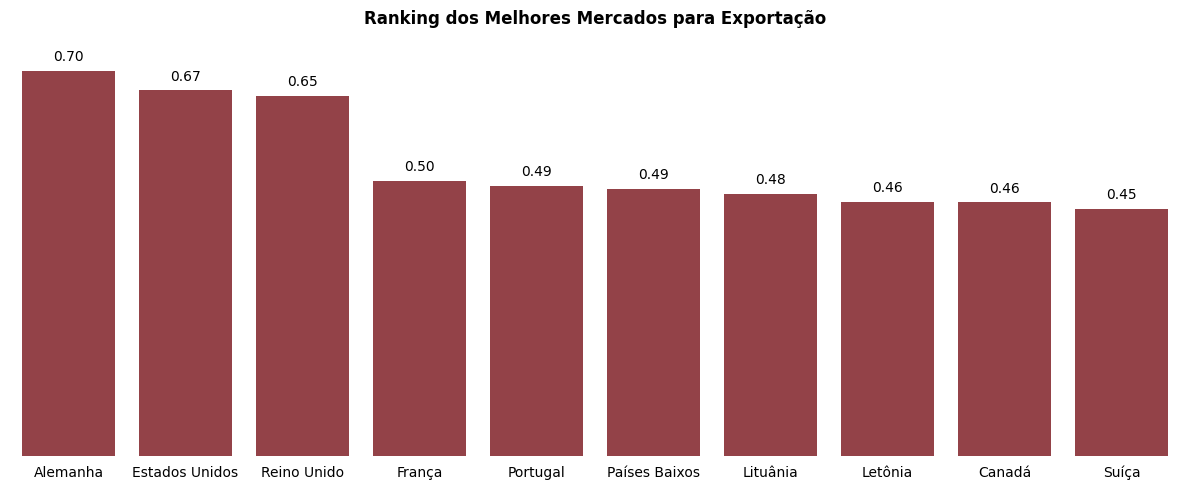

In [0]:
%python

# extraindo o top 10 melhores países para investir segundo o modelo matemático 
top_10_modelo = dados_externos.head(10)
#criando a figura
plt.figure(figsize=(12,5))
#criando o grafico 
grafico_modelo_matematico = sns.barplot(data = top_10_modelo, x = 'País',y = 'Pontuacao_Composta',color = '#A1343C')
# adicinando o rotulo de dados
for p in grafico_modelo_matematico.patches:
    grafico_modelo_matematico.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# chamando a função de costumização 
grafico_vertical(grafico_modelo_matematico,top_10_modelo['Pontuacao_Composta'],'Ranking dos Melhores Mercados para Exportação')